#**Практическое задание №1**

Установка необходимых пакетов:

In [1]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

Монтирование Вашего Google Drive к текущему окружению:

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [2]:
EVALUATE_ONLY = False
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

Импорт необходимых зависимостей:

In [6]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown

%matplotlib inline

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [11]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
        output = f'{name}.npz'
        gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui
To: C:\Users\user\DL\train_tiny.npz
100%|██████████| 105M/105M [00:34<00:00, 3.01MB/s] 


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.

Got numpy array of shape (224, 224, 3), and label with code 6.
Label code corresponds to NORM class.


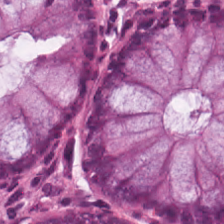

In [ ]:
d_train_tiny = Dataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

### Обёртка над Dataset для использования с PyTorch

In [4]:
# ============================================================
# (Опционально) Обёртка над Dataset для использования с PyTorch
# ============================================================

# ВНИМАНИЕ:
# Этот код нужен только тем, кто хочет решать задание с помощью PyTorch.
# Он показывает, как "подключить" наш Dataset к torch.utils.data.DataLoader.

try:
    import torch
    from torch.utils.data import Dataset as TorchDataset, DataLoader
    import torchvision.transforms as T
    from PIL import Image

    class HistologyTorchDataset(TorchDataset):
        """
        Обёртка над Dataset для использования с PyTorch.

        base_dataset: экземпляр Dataset('train'), Dataset('train_small'), etc.
        transform:    функция/объект, преобразующий изображение (PIL.Image -> torch.Tensor).

        """
        def __init__(self, base_dataset, transform=None):
            self.base = base_dataset
            # Минимальный transform по умолчанию:
            # np.uint8 [0, 255] -> float32 [0.0, 1.0]
            self.transform = transform or T.ToTensor()

        def __len__(self):
            # Размер датасета
            return len(self.base.images)

        def __getitem__(self, idx):
            """
            Возвращает (image_tensor, label) для PyTorch.
            image_tensor: torch.Tensor формы [3, H, W]
            label: int
            """
            img, label = self.base.image_with_label(idx)  # img: np.ndarray (H, W, 3)
            img = Image.fromarray(img)                    # в PIL.Image
            img = self.transform(img)                     # в torch.Tensor
            return img, label

except ImportError:
    HistologyTorchDataset = None
    print("PyTorch / torchvision не найдены. Обёртка HistologyTorchDataset недоступна.")

### Пример использвания класса HistologyTorchDataset

In [ ]:
if "HistologyTorchDataset" not in globals() or HistologyTorchDataset is None:
    print("PyTorch не установлен или обёртка недоступна — пример пропущен.")
else:
    print("Пример использования PyTorch-обёртки над Dataset")

    base_train = Dataset('train_tiny')

    # Создаём PyTorch-совместимый датасет
    train_ds = HistologyTorchDataset(base_train)

    # DataLoader автоматически создаёт батчи и перемешивает данные
    from torch.utils.data import DataLoader
    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)

    # Берём один батч и выводим информацию
    images_batch, labels_batch = next(iter(train_loader))

    print("Форма батча изображений:", tuple(images_batch.shape))  # [batch, 3, 224, 224]
    print("Форма батча меток:", tuple(labels_batch.shape))        # [batch]
    print("Пример меток:", labels_batch[:10].tolist())

    print("Тип images_batch:", type(images_batch))
    print("Тип labels_batch:", type(labels_batch))


---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [7]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import os

from tqdm.auto import tqdm

In [9]:
class Model:

    def __init__(self):

        #LBL1
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Device:", self.device)

        #LBL2
        self.num_classes = len(TISSUE_CLASSES)
        self.img_size = 224
        self.mean = (0.485, 0.456, 0.406)
        self.std  = (0.229, 0.224, 0.225)

        #LBL3
        self.model = models.efficientnet_b0(
            weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1
        )

        #LBL4
        in_features = self.model.classifier[-1].in_features
        self.model.classifier[-1] = nn.Linear(in_features, self.num_classes)

        self.model = self.model.to(self.device)

        #LBL5
        for p in self.model.features.parameters():
            p.requires_grad = False
        for p in self.model.classifier.parameters():
            p.requires_grad = True

        #LBL6
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(
            filter(lambda t: t.requires_grad, self.model.parameters()), lr=1e-3
        )

        #LBL7
        self.train_tfms = T.Compose([
            T.Resize((self.img_size, self.img_size)),
            T.RandomHorizontalFlip(p=0.5),
            T.ToTensor(),
            T.Normalize(self.mean, self.std),
        ])
        self.eval_tfms = T.Compose([
            T.Resize((self.img_size, self.img_size)),
            T.ToTensor(),
            T.Normalize(self.mean, self.std),
        ])

        self.best_path = "/content/drive/MyDrive/best.pth"



    #LBL8
    def _numpy_to_tensor(self, img: np.ndarray) -> torch.Tensor:
        if img.ndim == 2:
            pil = Image.fromarray(img.astype(np.uint8), mode="L").convert("RGB")
        else:
            if img.dtype != np.uint8:
                img = np.clip(img, 0, 255).astype(np.uint8)
            pil = Image.fromarray(img).convert("RGB")
        x = self.eval_tfms(pil).unsqueeze(0).to(self.device, non_blocking=True)  # [1,C,H,W]
        return x


    #LBL9
    def save(self, name: str):
        save_path = f"/content/drive/MyDrive/{name}.pth"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        torch.save({
            "state_dict": self.model.state_dict(),
            "num_classes": self.num_classes,
            "img_size": self.img_size,
            "mean": self.mean,
            "std": self.std,
        }, save_path)


    def load(self, name: str, strict: bool = True):

        pth_local = f"/content/drive/MyDrive/{name}.pth"

        #LBL10
        if not os.path.exists(pth_local):
            url = f"https://drive.google.com/file/d/12yyF0kExyaCGg1IGdIIovlDOIDJBC9G5/view?usp=drive_link"
            os.makedirs(os.path.dirname(pth_local), exist_ok=True)
            gdown.download(url, pth_local, quiet=False, fuzzy=True)

        #LBL11
        chkpt = torch.load(pth_local, map_location=self.device)

        #LBL12
        n_classes = int(chkpt.get("num_classes", self.num_classes))

        #LBL13
        state = chkpt.get("state_dict", chkpt)
        self.model.load_state_dict(state, strict=strict)

        #LBL14
        self.img_size = int(chkpt.get("img_size", self.img_size))
        self.mean = tuple(chkpt.get("mean", self.mean))
        self.std  = tuple(chkpt.get("std", self.std))

        self.train_tfms = T.Compose([
            T.Resize((self.img_size, self.img_size)),
            T.RandomHorizontalFlip(p=0.5),
            T.ToTensor(),
            T.Normalize(self.mean, self.std),
        ])
        self.eval_tfms = T.Compose([
            T.Resize((self.img_size, self.img_size)),
            T.ToTensor(),
            T.Normalize(self.mean, self.std),
        ])

        print(f"Loaded weights from {pth_local}")


    # LBL15
    def _evaluate(self, loader):
        self.model.eval()
        total_loss, total_corr, total_n = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in loader:
                images = images.to(self.device, non_blocking=True)
                labels = torch.as_tensor(labels, device=self.device, dtype=torch.long)
                logits = self.model(images)
                loss = self.criterion(logits, labels)
                bs = labels.size(0)
                total_loss += loss.item() * bs
                total_corr += (logits.argmax(1) == labels).sum().item()
                total_n += bs
        avg_loss = total_loss / max(1, total_n)
        avg_acc  = 100.0 * total_corr / max(1, total_n)
        return avg_loss, avg_acc

    def train(self, dataset, val_dataset=None):

        print("training started")

        #LBL16
        train_ds = HistologyTorchDataset(dataset, transform=self.train_tfms)
        train_loader = DataLoader(
            train_ds, batch_size=32, shuffle=True,
            num_workers=0, pin_memory=(self.device.type == "cuda")
        )

        val_loader = None
        if val_dataset is not None:
            val_ds = HistologyTorchDataset(val_dataset, transform=self.eval_tfms)
            val_loader = DataLoader(
                val_ds, batch_size=64, shuffle=False,
                num_workers=0, pin_memory=(self.device.type == "cuda")
            )

        #LBL17
        max_epochs = 30

        #LBL18
        train_accs = []
        val_accs = []
        train_losses = []
        val_losses = []

        #LBL19
        for epoch in tqdm(range(max_epochs), total=max_epochs, desc="Epochs", position=0, leave=True):
            self.model.train()
            run_loss = 0.0
            run_corr = 0
            run_n    = 0

            for images, labels in tqdm(train_loader, desc="Train", position=1, leave=False):
                images = images.to(self.device, non_blocking=True)
                labels = torch.as_tensor(labels, device=self.device, dtype=torch.long)

                #LBL20
                self.optimizer.zero_grad(set_to_none=True)
                #LBL21
                logits = self.model(images)
                #LBL22
                loss = self.criterion(logits, labels)
                #LBL23
                loss.backward()
                self.optimizer.step()

                #LBL24
                bs = labels.size(0)
                run_loss += loss.item() * bs
                run_corr += (logits.argmax(1) == labels).sum().item()
                run_n    += bs

            train_loss = run_loss / max(1, run_n)
            train_acc  = 100.0 * run_corr / max(1, run_n)

            #LBL25
            if val_loader is not None:
                val_loss, val_acc = self._evaluate(val_loader)
                #LBL26
                print(f"Epoch {epoch+1:02d}/{max_epochs} | "
                      f"train_loss={train_loss:.4f} train_acc={train_acc:.2f}% | "
                      f"val_loss={val_loss:.4f} val_acc={val_acc:.2f}%")
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                train_accs.append(train_acc)
                val_accs.append(val_acc)
            else:
                print(f"Epoch {epoch+1:02d}/{max_epochs} | "
                      f"train_loss={train_loss:.4f} train_acc={train_acc:.2f}%")

        print("training done")
        return train_losses, val_losses, train_accs, val_accs


    def test_on_dataset(self, dataset, limit=None):
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        for img in tqdm(dataset.images_seq(n), total=n):
            predictions.append(self.test_on_image(img))
        return predictions

    #LBL27
    def test_on_image(self, img: np.ndarray):
        self.model.eval()
        with torch.no_grad():
            x = self._numpy_to_tensor(img)
            logits = self.model(x)
            pred = int(logits.argmax(1).item())
        return pred

---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [10]:
d_train = Dataset('train')
d_test = Dataset('test')

Done. Dataset train consists of 18000 images.
Done. Dataset test consists of 4500 images.


In [13]:
model = Model()
if not EVALUATE_ONLY:
    train_losses, val_losses, train_accs, val_accs = model.train(d_train, d_test)
    model.save('best')
else:
    #todo: your link goes here
    model.load('best')

Device: cuda
training started


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 01/30 | train_loss=0.4461 train_acc=87.89% | val_loss=0.2017 val_acc=94.20%


Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 02/30 | train_loss=0.2333 train_acc=92.60% | val_loss=0.1601 val_acc=95.53%


Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 03/30 | train_loss=0.2077 train_acc=93.48% | val_loss=0.1456 val_acc=95.62%


Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 04/30 | train_loss=0.1899 train_acc=93.99% | val_loss=0.1363 val_acc=95.93%


Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 05/30 | train_loss=0.1820 train_acc=94.14% | val_loss=0.1699 val_acc=95.69%


Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 06/30 | train_loss=0.1731 train_acc=94.27% | val_loss=0.1237 val_acc=96.38%


Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 07/30 | train_loss=0.1697 train_acc=94.18% | val_loss=0.1205 val_acc=96.36%


Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 08/30 | train_loss=0.1710 train_acc=94.49% | val_loss=0.1187 val_acc=96.29%


Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 09/30 | train_loss=0.1665 train_acc=94.29% | val_loss=0.1291 val_acc=96.22%


Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 10/30 | train_loss=0.1595 train_acc=94.62% | val_loss=0.1213 val_acc=96.18%


Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 11/30 | train_loss=0.1600 train_acc=94.51% | val_loss=0.1221 val_acc=96.07%


Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 12/30 | train_loss=0.1609 train_acc=94.59% | val_loss=0.1119 val_acc=96.31%


Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 13/30 | train_loss=0.1528 train_acc=94.72% | val_loss=0.1163 val_acc=96.16%


Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 14/30 | train_loss=0.1576 train_acc=94.78% | val_loss=0.1168 val_acc=96.27%


Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 15/30 | train_loss=0.1543 train_acc=94.79% | val_loss=0.1179 val_acc=96.00%


Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 16/30 | train_loss=0.1516 train_acc=94.86% | val_loss=0.1109 val_acc=96.58%


Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 17/30 | train_loss=0.1581 train_acc=94.72% | val_loss=0.1137 val_acc=96.42%


Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 18/30 | train_loss=0.1531 train_acc=94.53% | val_loss=0.1260 val_acc=95.98%


Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 19/30 | train_loss=0.1526 train_acc=94.69% | val_loss=0.1110 val_acc=96.40%


Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 20/30 | train_loss=0.1548 train_acc=94.80% | val_loss=0.1119 val_acc=96.42%


Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 21/30 | train_loss=0.1488 train_acc=94.77% | val_loss=0.1106 val_acc=96.22%


Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 22/30 | train_loss=0.1513 train_acc=94.94% | val_loss=0.1103 val_acc=96.51%


Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 23/30 | train_loss=0.1485 train_acc=95.00% | val_loss=0.1064 val_acc=96.62%


Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 24/30 | train_loss=0.1533 train_acc=94.79% | val_loss=0.1083 val_acc=96.42%


Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 25/30 | train_loss=0.1521 train_acc=94.90% | val_loss=0.1086 val_acc=96.67%


Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 26/30 | train_loss=0.1515 train_acc=94.78% | val_loss=0.1158 val_acc=96.31%


Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 27/30 | train_loss=0.1496 train_acc=94.94% | val_loss=0.1064 val_acc=96.42%


Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 28/30 | train_loss=0.1531 train_acc=94.71% | val_loss=0.1119 val_acc=96.58%


Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 29/30 | train_loss=0.1482 train_acc=95.01% | val_loss=0.1118 val_acc=96.24%


Train:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 30/30 | train_loss=0.1457 train_acc=94.96% | val_loss=0.1120 val_acc=96.73%
training done


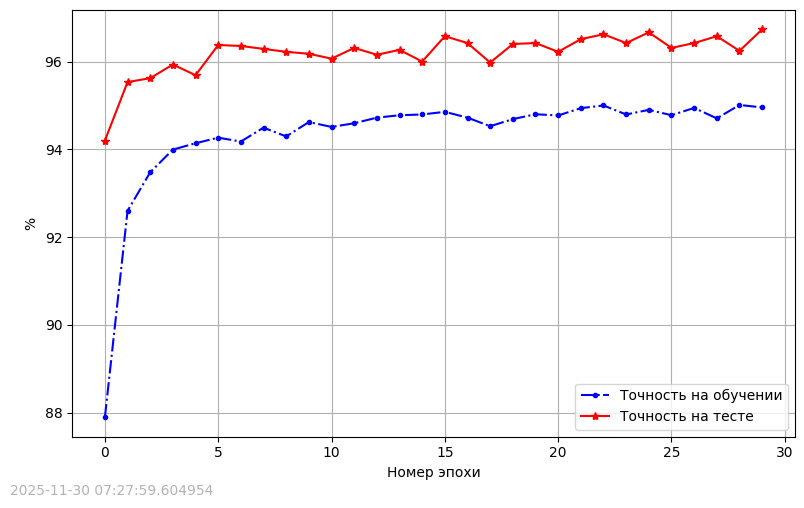

In [14]:
#LBL28
import matplotlib.pyplot as plt
from datetime import datetime

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(train_accs, label="Точность на обучении", color='blue', marker='.', linestyle='-.')
ax.plot(val_accs, label="Точность на тесте", color='red', marker='*')

ax.set_xlabel("Номер эпохи")
ax.set_ylabel("$\\%$")

ax.grid(True)
ax.legend()

fig.text(
    0.0, 0.0, str(datetime.now()),
    fontsize=10, color='gray', alpha=0.6,
)

fig.tight_layout()
plt.show()

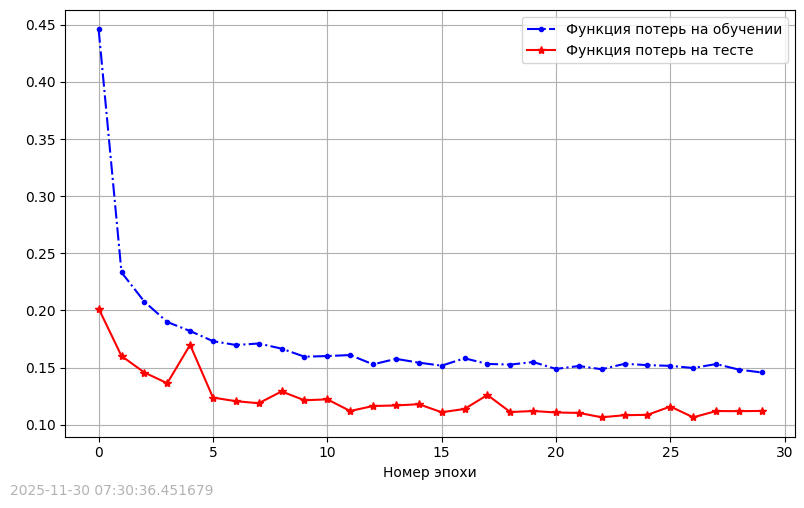

In [16]:
#LBL29
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(train_losses, label="Функция потерь на обучении", color='blue', marker='.', linestyle='-.')
ax.plot(val_losses, label="Функция потерь на тесте", color='red', marker='*')

ax.set_xlabel("Номер эпохи")

ax.grid(True)
ax.legend()

fig.text(
    0.0, 0.0, str(datetime.now()),
    fontsize=10, color='gray', alpha=0.6,
)

fig.tight_layout()
plt.show()

In [12]:
EVALUATE_ONLY = True

model = Model()
model.load('best')

Device: cuda
Loaded weights from /content/drive/MyDrive/best.pth


Пример тестирования модели на части набора данных:

In [13]:
# evaluating model on 10% of test dataset
pred_1 = model.test_on_dataset(d_test, limit=0.1)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '10% of test')

  0%|          | 0/450 [00:00<?, ?it/s]

metrics for 10% of test:
	 accuracy 0.9978:
	 balanced accuracy 0.9978:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Пример тестирования модели на полном наборе данных:

In [14]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels, pred_2, 'test')

  0%|          | 0/4500 [00:00<?, ?it/s]

metrics for test:
	 accuracy 0.9673:
	 balanced accuracy 0.9673:


Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [12]:
final_model = Model()
final_model.load('best')
d_test_tiny = Dataset('test_tiny')
pred = final_model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

Device: cuda
Loaded weights from /content/drive/MyDrive/best.pth
Done. Dataset test_tiny consists of 90 images.


  0%|          | 0/90 [00:00<?, ?it/s]

metrics for test-tiny:
	 accuracy 0.9778:
	 balanced accuracy 0.9778:


Отмонтировать Google Drive.

In [11]:
drive.flush_and_unmount()

---
# Дополнительные "полезности"

Ниже приведены примеры использования различных функций и библиотек, которые могут быть полезны при выполнении данного практического задания.

### Измерение времени работы кода

Измерять время работы какой-либо функции можно легко и непринужденно при помощи функции timeit из соответствующего модуля:

In [ ]:
import timeit

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res


def f():
    return factorial(n=1000)

n_runs = 128
print(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')

### Scikit-learn

Для использования "классических" алгоритмов машинного обучения рекомендуется использовать библиотеку scikit-learn (https://scikit-learn.org/stable/). Пример классификации изображений цифр из набора данных MNIST при помощи классификатора SVM:

In [ ]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))

# Матрица ошибок + визуализация в новом API
cm = metrics.confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classifier.classes_)

fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax)
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()

### Scikit-image

Реализовывать различные операции для работы с изображениями можно как самостоятельно, работая с массивами numpy, так и используя специализированные библиотеки, например, scikit-image (https://scikit-image.org/). Ниже приведен пример использования Canny edge detector.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

### Tensorflow 2

Для создания и обучения нейросетевых моделей можно использовать фреймворк глубокого обучения Tensorflow 2. Ниже приведен пример простейшей нейроной сети, использующейся для классификации изображений из набора данных MNIST.

In [ ]:
# Install TensorFlow

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

<font color="red">
Для эффективной работы с моделями глубокого обучения убедитесь в том, что в текущей среде Google Colab используется аппаратный ускоритель GPU или TPU. Для смены среды выберите "среда выполнения" -> "сменить среду выполнения".
</font>

Большое количество туториалов и примеров с кодом на Tensorflow 2 можно найти на официальном сайте https://www.tensorflow.org/tutorials?hl=ru.

Также, Вам может понадобиться написать собственный генератор данных для Tensorflow 2. Скорее всего он будет достаточно простым, и его легко можно будет реализовать, используя официальную документацию TensorFlow 2. Но, на всякий случай (если не удлось сразу разобраться или хочется вникнуть в тему более глубоко), можете посмотреть следующий отличный туториал: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

### PyTorch

In [ ]:
# ============================================================
# Дополнительно: мини-демо PyTorch
# ============================================================
# Ранний выход, если PyTorch/обёртка недоступны
try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import DataLoader
except ImportError:
    print("PyTorch не установлен — демо пропущено.")
    import sys
    raise SystemExit

if "HistologyTorchDataset" not in globals() or HistologyTorchDataset is None:
    print("HistologyTorchDataset недоступна — демо пропущено.")
    import sys
    raise SystemExit


# --- Данные: tiny-наборы, чтобы выполнялось быстро ---
base_train = Dataset('train_tiny')
base_test  = Dataset('test_tiny')

train_ds = HistologyTorchDataset(base_train)           # ToTensor по умолчанию
test_ds  = HistologyTorchDataset(base_test)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

# --- Мини-модель: двухслойный CNN + один FC (демонстрация, не решение) ---
class TinyCNN(nn.Module):
    def __init__(self, num_classes=len(TISSUE_CLASSES)):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)  # 224->112->56
        self.fc    = nn.Linear(16 * 56 * 56, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 3, 224, 224] -> [B, 8, 112, 112]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 8, 112, 112] -> [B, 16, 56, 56]
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = TinyCNN(num_classes=len(TISSUE_CLASSES)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- Один учебный шаг "обучения" на одном батче ---
model.train()
xb, yb = next(iter(train_loader))
xb = xb.to(device)
yb = yb.to(device, dtype=torch.long)

optimizer.zero_grad()
logits = model(xb)
loss = criterion(logits, yb)
float_loss = float(loss.detach().cpu())
loss.backward()
optimizer.step()

print(f"Loss на одном батче train_tiny: {float_loss:.4f}")

# --- Быстрая проверка на одном батче теста (для формы вывода/метрик) ---
model.eval()
with torch.no_grad():
    xt, yt = next(iter(test_loader))
    xt = xt.to(device)
    logits_t = model(xt).cpu()
    y_pred = logits_t.argmax(dim=1).numpy()
    y_true = yt.numpy()

print("Размерности:", {"y_true": y_true.shape, "y_pred": y_pred.shape})
Metrics.print_all(y_true, y_pred, "_")  # balanced accuracy/accuracy на одном батче для демонстрации

# для полноценного решения требуется собственный тренировочный цикл по эпохам,
# аугментации/нормализация, сохранение/загрузка весов, и тестирование на всём наборе.

### Дополнительные ресурсы по PyTorch

- **Официальные туториалы PyTorch** — https://pytorch.org/tutorials/  
- **“Deep Learning with PyTorch: 60-Minute Blitz”** — https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
- **Transfer Learning for Computer Vision** — https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html  
- **PyTorch Get Started (установка)** — https://pytorch.org/get-started/locally/  
- **Dive into Deep Learning (D2L, глава PyTorch)** — https://d2l.ai/chapter_preliminaries/index.html  
- **Fast.ai — Practical Deep Learning for Coders** — https://course.fast.ai/  
- **Learn PyTorch.io (Zero to Mastery)** — https://www.learnpytorch.io/

### Numba

В некоторых ситуациях, при ручных реализациях графовых алгоритмов, выполнение многократных вложенных циклов for в python можно существенно ускорить, используя JIT-компилятор Numba (https://numba.pydata.org/).
Примеры использования Numba в Google Colab можно найти тут:
1. https://colab.research.google.com/github/cbernet/maldives/blob/master/numba/numba_cuda.ipynb
2. https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb

> Пожалуйста, если Вы решили использовать Numba для решения этого практического задания, еще раз подумайте, нужно ли это Вам, и есть ли возможность реализовать требуемую функциональность иным способом. Используйте Numba только при реальной необходимости.



### Работа с zip архивами в Google Drive

Запаковка и распаковка zip архивов может пригодиться при сохранении и загрузки Вашей модели. Ниже приведен фрагмент кода, иллюстрирующий помещение нескольких файлов в zip архив с последующим чтением файлов из него. Все действия с директориями, файлами и архивами должны осущетвляться с примонтированным Google Drive.


Создадим 2 изображения, поместим их в директорию tmp внутри PROJECT_DIR, запакуем директорию tmp в архив tmp.zip.

In [ ]:
PROJECT_DIR = "/dev/prak_nn_1/"
arr1 = np.random.rand(100, 100, 3) * 255
arr2 = np.random.rand(100, 100, 3) * 255

img1 = Image.fromarray(arr1.astype('uint8'))
img2 = Image.fromarray(arr2.astype('uint8'))

p = "/content/drive/MyDrive/" + PROJECT_DIR

if not (Path(p) / 'tmp').exists():
    (Path(p) / 'tmp').mkdir()

img1.save(str(Path(p) / 'tmp' / 'img1.png'))
img2.save(str(Path(p) / 'tmp' / 'img2.png'))

%cd $p
!zip -r "tmp.zip" "tmp"

Распакуем архив tmp.zip в директорию tmp2 в PROJECT_DIR. Теперь внутри директории tmp2 содержится директория tmp, внутри которой находятся 2 изображения.

In [ ]:
p = "/content/drive/MyDrive/" + PROJECT_DIR
%cd $p
!unzip -uq "tmp.zip" -d "tmp2"